In [2]:
import numpy as np
import random
import logging
from LoopStructural.utils.helper import rotation
from LoopStructural import GeologicalModel
import lavavu
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural import GeologicalModel
from LoopStructural.utils import log_to_file
from LoopStructural.analysis import displacement_missfit
log_to_file('test')

fault_params = {'interpolatortype':'FDI',
                'nelements':1e3,
#                 'data_region':.2, 
                'fault_buffer':0.4,
                'solver':'pyamg',
#                 overprints:overprints,
                'cpw':10,
                'npw':10}
foliation_params = {'nelements':1e4,  # how many tetras/voxels
                    'buffer':2.5,  # how much to extend nterpolation around box
                    'solver':'pyamg',
                    'npw':10,
                    'cpw':10,
                    'interpolatortype':'FDI',
                    'damp':True}
# global evaluate_value_calls 
model, m2l_data = GeologicalModel.from_map2loop_directory('./interactive_model-wa',
                                                        skip_faults=False,
                                                          rescale=False,
                                                          evaluate=False,
                                                        fault_params=fault_params,
                                                        foliation_params=foliation_params,
                                                         unconformities=False)
# for f in model.features:
#     if f.type == 'fault':
#         print(f[0].interpolator.nx)
#     else:
#         print(f.interpolator.nx)
model.update()

In [3]:
view = LavaVuModelViewer(model)
view.add_model_surfaces()
view.add_data(model['supergroup_0'])
view.interactive()

2021-03-05 00:08:56,815 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-03-05 00:08:56,815 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box


Adding surfaces took 0.8242974281311035 seconds



In [9]:
fname='Fault_8909'


In [10]:
from LoopStructural.analysis import displacement_missfit
from LoopStructural.utils.helper import rotation
angle = 30
fault_center = model.stratigraphic_column['faults'][fname]['FaultCenter']
fault_influence = m2l_data['stratigraphic_column']['faults'][fname]['InfluenceDistance']
fault_extent = m2l_data['stratigraphic_column']['faults'][fname]['HorizontalRadius'] 
fault_vertical_radius = m2l_data['stratigraphic_column']['faults'][fname]['VerticalRadius']
mask2 = np.logical_and(m2l_data['data']['feature_name']==fname,~np.isnan(m2l_data['data']['gx']))
fault_normal = m2l_data['data'].loc[mask2,['gx','gy','gz']].mean().to_numpy()
fault_normal /= np.linalg.norm(fault_normal)


In [11]:
import numpy as np
import numpy as np
def plane_fit(points):
    
    soln = []
#     points = points.loc[~np.isnan(points['val']),['X','Y','Z','val']]
    A=np.zeros((len(points)*4,4))
    B=np.zeros((len(points)*4))
    val_mask = ~np.isnan(points['val'])
    vec_mask = ~np.isnan(points['nx'])
    c = 0
    xyz = points.loc[val_mask,['X','Y','Z']].to_numpy()
    A[:len(points[val_mask]),:3] = xyz[:,:3]
    A[:len(points[val_mask]),3]=1.
    B[:len(points[val_mask])] = points.loc[val_mask,'val'].to_numpy()#v#np.zeros(A.shape[0])
    c = len(points[val_mask])
    A[c:len(points[vec_mask])+c,0] = 1
    B[c:len(points[vec_mask])+c] = points.loc[vec_mask,'nx'].to_numpy()
    c+=len(points[vec_mask])
    A[c:len(points[vec_mask])+c,1] = 1
    B[c:len(points[vec_mask])+c] = points.loc[vec_mask,'ny'].to_numpy()
    c+=len(points[vec_mask])
    A[c:len(points[vec_mask])+c,2] = 1
    B[c:len(points[vec_mask])+c] = points.loc[vec_mask,'nz'].to_numpy()
    c+=len(points[vec_mask])
    x = np.linalg.lstsq(A[:c,:],B[:c],rcond=None)[0]
    soln.append(x)
#     print(B)
    return soln

class PlaneFitFeature:
    def __init__(self,data,name='Plane',model=None):
        self.soln = np.array(plane_fit(data)).T
        self.name = name
        self.model = model
    def evaluate_value(self,xyz):
        if self.model:
            xyz = self.model.rescale(xyz,inplace=False)
        return xyz[:,0]*self.soln[None,0]+xyz[:,1]*self.soln[None,1]+xyz[:,2]*self.soln[None,2]+self.soln[None,3]
    def min(self):

        return -np.inf
    def max(self):
        return np.inf
    def evaluate_gradient(self,xyz):
        grad = np.zeros_like(xyz)
        grad[:,0] = self.soln[None,0]
        grad[:,1] = self.soln[None,1]
        grad[:,2] = self.soln[None,2]
        return grad
def displacement_missfit(d,
                            fault_slip,
                            fault_center, 
                            fault_influence, 
                            fault_extent, 
                            fault_vertical_radius, 
                            fault_normal,
                            fname,
                            model,
                            fault_params,
                            view=None):
    ## create the fault in the model
    if view is not None:
        view.clear()
    model.create_and_add_fault(fname,
                                d,
                                faultfunction='BaseFault',
                                fault_slip_vector=fault_slip,
                                fault_center=fault_center,
                                fault_extent=fault_extent,
                                fault_influence=fault_influence,
                                fault_vectical_radius=fault_vertical_radius,
#                                 overprints=overprints,
                                **fault_params,
                                )
    # run interpolator
    model[fname].builder.update()
    # determine which points are inside the fault volume
    v = model[fname].faultframe.evaluate_value(model.data[['X','Y','Z']].to_numpy())
    np.all(np.logical_and(v > -1,v<1),axis=1)
    mask = model[fname].inside_volume(model.data[['X','Y','Z']].to_numpy())
    if np.sum(mask) == 0:
        view.rotation = [-12.21526050567627, 40.99689483642578, 57.64434051513672]
        view.add_data(model[fname][0])
        view.add_data(model[fname][1])
        view.add_data(model[fname][2])

        view.add_isosurface(model[fname][0],slices=[-1,0,1])
        view.add_isosurface(model[fname][1],slices=[-1,0,1])
        view.add_isosurface(model[fname][2],slices=[-1,0,1])
        view.add_isosurface(model[fname][0])
        view.add_isosurface(model[fname][1])
        view.add_isosurface(model[fname][2])
        view.add_scalar_field(model[fname].displacementfeature)
        view.display()
        raise BaseException
        return None, None, None, None, None
    data2 = model.data.copy()

    # mask only data associated with the faulted strati
    mask = np.logical_and(mask,model.data['feature_name']=='supergroup_0')
    if view is not None:
        view.add_isosurface(model[fname],value=0)
    value_data = data2.loc[mask,'val'].to_numpy()
    # gx = model[fname][0].evaluate_value(data2.loc[np.logical_and(~np.isnan(data2['val']),mask),['X','Y','Z']].to_numpy(),inplace=False))
    normals =data2.loc[np.logical_and(np.isnan(data2['val']),mask),
                            ['nx','ny','nz']].to_numpy()
    if view is not None:
        view.add_vector_field(model[fname],
                            locations=data2.loc[mask,['X','Y','Z']].to_numpy()
                            )
        view.add_value_data(model.rescale(data2.loc[mask,['X','Y','Z']].to_numpy(),inplace=False),
                            data2.loc[mask,['val']].to_numpy(),name='pts_before',
                            vmin=np.nanmin(value_data),
                            vmax=np.nanmax(value_data),cmap='rainbow')
        view.add_orientation_disks(model.rescale(data2.loc[np.logical_and(np.isnan(data2['val']),mask),
                            ['X','Y','Z']].to_numpy(),inplace=False),
                                   normals,
                                   name='normals')
    data2.loc[mask,['X','Y','Z']] = model[fname].apply_to_points(data2.loc[mask,['X','Y','Z']].to_numpy())
    tmp_pts = data2.loc[mask,['X','Y','Z','val','nx','ny','nz']]
#     tmp_pts = tmp_pts.loc[~np.isnan(tmp_pts['val']),:]
    tmp_pts.loc[:,['X','Y','Z']] = model.rescale(tmp_pts.loc[:,['X','Y','Z']],inplace=False)
    fault_plane_feature = PlaneFitFeature(tmp_pts,'Plane_Fit_{}'.format(fname),model=model)
    
    dv =data2.loc[np.logical_and(~np.isnan(data2['val']),mask),'val'].to_numpy()
    estimated_normal = fault_plane_feature.evaluate_gradient(data2.loc[np.logical_and(np.isnan(data2['val']),mask),
                            ['X','Y','Z']].to_numpy())
    if view is not None:
        view.add_value_data(model.rescale(data2.loc[np.logical_and(~np.isnan(data2['val']),mask),
                            ['X','Y','Z']].to_numpy(),inplace=False),
                            dv,
                            name='points_after',
                            vmin=np.nanmin(value_data),
                            vmax=np.nanmax(value_data),
                            cmap='rainbow')
        view.add_orientation_disks(model.rescale(data2.loc[np.logical_and(np.isnan(data2['val']),mask),
                            ['X','Y','Z']].to_numpy(),inplace=False),
                                   estimated_normal,
                                   name='estimated_normal')
        view.add_isosurface(fault_plane_feature,
                            slices=np.unique(dv),
                            paint_with=fault_plane_feature,
                            vmin=np.nanmin(value_data),
                            vmax=np.nanmax(value_data),
                            cmap='rainbow')
    fv = fault_plane_feature.evaluate_value(data2.loc[np.logical_and(~np.isnan(data2['val']),mask),['X','Y','Z']].to_numpy())
    return fv, dv, fault_plane_feature, estimated_normal, normals

In [42]:
def build_model(d,
                            fault_slip,
                            fault_center, 
                            fault_influence, 
                            fault_extent, 
                            fault_vertical_radius, 
                            fault_normal,
                            fname,
                            model,
                            fault_params,
                            view=None):
    ## create the fault in the model
    if view is not None:
        view.clear()
    model.create_and_add_fault(fname,
                                d,
                                faultfunction='BaseFault',
                                fault_slip_vector=fault_slip,
                                fault_center=fault_center,
                                fault_extent=fault_extent,
                                fault_influence=fault_influence,
                                fault_vectical_radius=fault_vertical_radius,
#                                 overprints=overprints,
                                **fault_params,
                                )
    # run interpolator
    model[fname].builder.update()
    model.update()
    strat_v = model['supergroup_0'].evaluate_value(model.regular_grid(shuffle=False,))
    return strat_v

In [12]:
%load_ext snakeviz
fault_params['nelements']=1e3

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [13]:
model[fname].displacementfeature

In [14]:
v = np.dot(rotation(fault_normal,30),np.array([0,0,1]))
dv, fv, feature, en, n = displacement_missfit(-250,v,fault_center,fault_influence,fault_extent,fault_vertical_radius,fault_normal,fname,model,fault_params,view=view)
view.interactive()

In [104]:
view.interactive()

In [54]:
view.rotation

[-68.56714630126953, 29.501142501831055, 4.145428657531738]

In [18]:
%%prun
na = 90
nd = 100
dmin=-400
dmax=400
images = {}
diff = np.zeros((nd,na))
for i, d in enumerate(np.linspace(dmin,dmax,nd)):
    for j, a in enumerate(np.linspace(-90,90,na)):
        v = np.dot(rotation(fault_normal,a),np.array([0,0,1]))
        dv, fv, feature, en, n = displacement_missfit(d,v,fault_center,fault_influence,fault_extent,fault_vertical_radius,fault_normal,fname,model,fault_params,view=view)
        if feature is None:
            print('did not work for displacement = {} and angle = {}'.format(d,a))
            diff[i,j] = np.nan
            continue
        view.rotation = [-82.77803802490234, -45.72848892211914, 1.6532998085021973]
        images[(d,a)] = view.image_array()
        en/=np.linalg.norm(en,axis=1)[:,None]
        n/=np.linalg.norm(n,axis=1)[:,None]

        diff[i,j] = np.sum(np.abs(dv-fv))*np.abs(np.mean(np.sum(en*n,axis=1)))
# view.interactive()

In [17]:
%%prun
dv, fv, feature, en, n = displacement_missfit(100,v,fault_center,fault_influence,fault_extent,fault_vertical_radius,fault_normal,fname,model,fault_params,view=view)

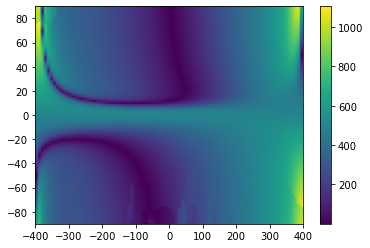

In [19]:
import matplotlib.pyplot as plt
plt.imshow(diff,extent=(dmin,dmax,-90,90),aspect='auto')
plt.colorbar()

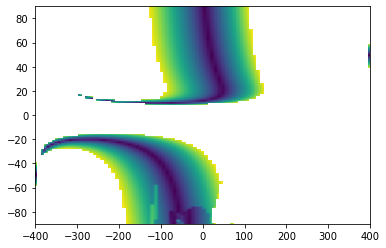

In [29]:
diff_masked = np.copy(diff)
diff_masked[diff_masked>200] = np.nan
plt.imshow(diff_masked,extent=(dmin,dmax,-90,90),aspect='auto')

In [33]:
i,j  = np.where(~np.isnan(diff_masked))

In [36]:
angles, distance = np.meshgrid(np.linspace(-90,90,na),np.linspace(dmin,dmax,nd))
angles_to_run = angles[i,j].flatten()
distance_to_run = distance[i,j].flatten()


In [38]:
values = np.zeros((model.regular_grid().shape[0],100))
for a, d in zip(angles_to_run[:100],distance_to_run[:100]):
    v = np.dot(rotation(fault_normal,a),np.array([0,0,1]))
build_model(d,v,fault_center,fault_influence,fault_extent,fault_vertical_radius,fault_normal,fname,model,fault_params,view=view)

(2603,)

In [43]:
a = angles_to_run[0]
d = distance_to_run[0]
v = np.dot(rotation(fault_normal,a),np.array([0,0,1]))

values = build_model(d,v,fault_center,fault_influence,fault_extent,fault_vertical_radius,fault_normal,fname,model,fault_params,view=view)

array([-6509.72791844, -6678.42249554, -6847.11707263, ...,
       -5429.17569616, -5596.54093944, -5763.95687442])

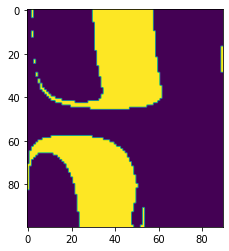

In [34]:
test = np.zeros(diff.shape)
test[i,j] = 1
plt.imshow(test)

In [25]:
v = np.dot(rotation(fault_normal,40),np.array([0,0,1]))
dv, fv, feature, en, n = displacement_missfit(-400,v,fault_center,fault_influence,fault_extent,fault_vertical_radius,fault_normal,fname,model,fault_params,view=view)
view.interactive()

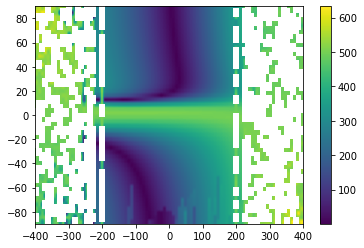

In [78]:
import matplotlib.pyplot as plt
plt.imshow(diff,extent=(dmin,dmax,-90,90),aspect='auto')
plt.colorbar()

In [13]:
fault_influence

array([1965.88572024])

In [14]:
fault_vertical_radius

array([3931.77144047])

In [56]:
v = np.dot(rotation(fault_normal,-30),np.array([0,0,1]))
dv, fv, feature, en, n = displacement_missfit(-200,v,fault_center,fault_influence,fault_extent,fault_vertical_radius,fault_normal,fname,model,fault_params,view=view)
# view.add_data(model['supergroup_0'])
# view.add_scalar_field(model[fname].displacementfeature)
view.add_data(model[fname][0])
view.add_data(model[fname][1])
view.add_data(model[fname][2])
view.rotation = [-12.21526050567627, 40.99689483642578, 57.64434051513672]
view.add_isosurface(model[fname][0],slices=[-1,1])
view.add_isosurface(model[fname][1],slices=[-1,1])
view.add_isosurface(model[fname][2],slices=[-1,1])

view.interactive()

2021-03-02 07:03:01,192 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-03-02 07:03:01,192 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-03-02 07:03:01,240 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-03-02 07:03:01,240 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-03-02 07:03:01,242 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-03-02 07:03:01,242 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box


In [36]:
fault_params['nelements']=5e3
for a in np.linspace(-90,90,10):
    v = np.dot(rotation(fault_normal,90),np.array([0,0,1]))
    print(a)
    try:
        dv, fv, feature, en, n = displacement_missfit(-200,v,fault_center,fault_influence,fault_extent,fault_vertical_radius,fault_normal,fname,model,fault_params,view=view)
    except:
        print('didnt work')
    # view.add_data(model['supergroup_0'])
    # view.add_scalar_field(model[fname].displacementfeature)
    # view.add_data(model[fname][0])
    # view.add_data(model[fname][1])
    # view.add_data(model[fname][2])
    view.rotation = [-12.21526050567627, 40.99689483642578, 57.64434051513672]
    # view.add_isosurface(model[fname][0],slices=[-1,1])
    # view.add_isosurface(model[fname][1],slices=[-1,1])
    # view.add_isosurface(model[fname][2],slices=[-1,1])

    view.image('fault_displacement{}.png'.format(a))

-90.0
[]
didnt work
-70.0
[]
didnt work
-50.0
[   nan    nan    nan    nan    nan    nan    nan -4640. -4640. -4640.
 -4640. -3180. -3180. -3180. -3180. -3180. -3180.]
-30.0
[]
didnt work
-10.0
[   nan    nan    nan    nan    nan    nan    nan -4640. -4640. -4640.
 -4640. -3180. -3180. -3180. -3180. -3180. -3180.]
10.0
[]
didnt work
30.0
[   nan    nan    nan    nan    nan    nan    nan -4640. -4640. -4640.
 -4640. -3180. -3180. -3180. -3180. -3180. -3180.]
50.0
[]
didnt work
70.0
[   nan    nan    nan    nan    nan    nan    nan -4640. -4640. -4640.
 -4640. -3180. -3180. -3180. -3180. -3180. -3180.]
90.0
[   nan    nan    nan    nan    nan    nan    nan -4640. -4640. -4640.
 -4640. -3180. -3180. -3180. -3180. -3180. -3180.]


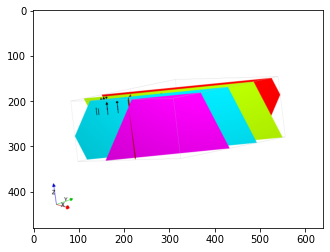

In [130]:
plt.imshow(images[(-262.0689655172414, 23.793103448275865)])

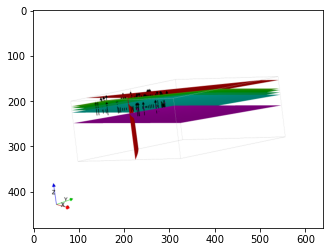

In [75]:
plt.imshow(images[(-50.,0.)])

In [77]:
model[fname][0].interpolator.support.nsteps

array([26, 27, 22])

In [22]:
model.feature_name_index

{'Fault_7344': 0,
 'Fault_5997': 1,
 'Fault_6205': 2,
 'supergroup_0': 3,
 'supergroup_0_unconformity': 4}

In [6]:
view = LavaVuModelViewer(model)
view.add_isosurface(model.features[1],value=0)
view.interactive()

In [16]:
model[fname][0].builder.update()
model[fname][1].builder.update()
model[fname][2].builder.update()
# model[fname][0].evaluate_value(model.regular_grid(rescale=False))

In [13]:
model[fname][0].is+i

[]

In [19]:
model[fname][0].builder.up_to_date()

In [20]:
printstring = ''
word = ['w','o','_','d']
for c in word:
    printstring+=c+' '
print(printstring)

w o _ d 


In [23]:
word = ['w','o','_','d']
format_string = '%s ' * 4 # length of word
print(format_string%tuple(word))

w o _ d 
